In [1]:

import sys
import pandas as pd
import datetime
import requests
import json
import numpy as np
from pandas import ExcelWriter
import os
import glob
import pytz
from dateutil.tz import gettz
import timeit
# from datetime import datetime
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_data(devid, acc_token, address, start_time, end_time):
    df=pd.DataFrame([])
    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    if r2:
        
        # read all descriptors at once
        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [desc]
            df = pd.concat([df,df1], axis = 1)
                   

        if df.empty == False:
        
            df.reset_index(drop=False, inplace=True)
            df['ts'] = pd.to_datetime(df['ts'], unit='ms')
            # df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert(tmzn).dt.tz_localize(None)
    
            # Set timestamp as index, convert all columns to float
            df = df.sort_values(by=['ts'])
            #df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert(tmzn)
            df.reset_index(drop=True, inplace=True)
            df.set_index('ts',inplace = True, drop = True)
            for col in df.columns:
                df[col] = df[col].astype('float')
    return df

In [4]:
# did ={'102.104.000220':'2e092150-07a5-11ea-a66e-7bc859fa1c1b','102.201.000662':'c1ca6800-07a4-11ea-a66e-7bc859fa1c1b','102.201.000665':'080958d0-07a5-11ea-a66e-7bc859fa1c1b'}
did={'102.116.000097':'20ae5023-070f-11ea-a66e-7bc859fa1c1b'}

In [5]:
devid = did['102.116.000097'] 
start_time = '1611222000000' # 6th of July 12:00 am utc
end_time = '1612867800000' # 21th of January 


#address = "http://157.230.210.37:8081"
address = "https://m3.zeb.gr"


r = requests.post(address + "/api/auth/login",json={'username': 'a.papagiannaki@meazon.com', 'password': 'eurobank'}).json()


# acc_token is the token to be used in the next request
acc_token = 'Bearer' + ' ' + r['token']

df = read_data(devid, acc_token, address, start_time, end_time)


In [8]:
df.tail(10)

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC
ts,,,,,,
2021-02-09 10:13:53,1792.644,1443.990,1409.211,NaN,NaN,NaN
2021-02-09 10:18:53,1577.721,1243.893,1261.530,NaN,NaN,NaN
2021-02-09 10:23:53,1950.182,1533.761,1385.316,NaN,NaN,NaN
2021-02-09 10:28:53,1586.320,1282.665,1192.348,NaN,NaN,NaN
2021-02-09 10:33:53,1316.648,1007.554,1047.564,NaN,NaN,NaN
2021-02-09 10:38:53,1918.464,1464.868,1482.792,NaN,NaN,NaN
2021-02-09 10:43:50,1749.692,1353.079,1365.602,NaN,NaN,NaN
2021-02-09 10:46:36,1506.650,1173.736,1214.009,NaN,NaN,NaN
2021-02-09 10:49:45,NaN,NaN,NaN,26027523.0,25607281.0,29951820.0


In [9]:
df = df.groupby(df.index).max()

df.index = df.index.ceil('5T')
df =  df .resample('5T').max()
df.tail()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC
ts,,,,,,
2021-02-09 10:30:00,1586.320,1282.665,1192.348,NaN,NaN,NaN
2021-02-09 10:35:00,1316.648,1007.554,1047.564,NaN,NaN,NaN
2021-02-09 10:40:00,1918.464,1464.868,1482.792,NaN,NaN,NaN
2021-02-09 10:45:00,1749.692,1353.079,1365.602,NaN,NaN,NaN
2021-02-09 10:50:00,1834.707,1441.680,1471.277,26027523.0,25607281.0,29951820.0


In [12]:
df = df.iloc[2:]
df.head()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC
ts,,,,,,
2021-01-21 09:55:00,3336.575,2725.246,2575.850,25537193.0,25282264.0,29587786.0
2021-01-21 10:00:00,3308.443,2682.851,2709.725,NaN,NaN,NaN
2021-01-21 10:05:00,3258.713,2667.480,2449.891,NaN,NaN,NaN
2021-01-21 10:10:00,2192.348,1763.003,2040.574,NaN,NaN,NaN
2021-01-21 10:15:00,2831.384,2204.239,2219.835,NaN,NaN,NaN


In [11]:
# df['pwrA'].iloc[-1] = df['pwrA'].iloc[-2]
# df['pwrB'].iloc[-1] = df['pwrB'].iloc[-2]
# df['pwrC'].iloc[-1] = df['pwrC'].iloc[-2]
# df.tail()

In [13]:
# df =  df .resample('5T').max()
df = df[df['pwrA'].notna()]
df = df[df['pwrB'].notna()]
df = df[df['pwrC'].notna()]

for pwr in ['pwrA','pwrB','pwrC']:
    while len(df.loc[df[pwr]<0,pwr])>0:
        df.loc[df[pwr]<0, pwr] = df[pwr].shift()

df['delta'] = np.nan
for i in range(1,df.shape[0]):
    df['delta'] = (df.index[i] - df.index[i-1]).total_seconds()

df.head()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,delta
ts,,,,,,,
2021-01-21 09:55:00,3336.575,2725.246,2575.850,25537193.0,25282264.0,29587786.0,300.0
2021-01-21 10:00:00,3308.443,2682.851,2709.725,NaN,NaN,NaN,300.0
2021-01-21 10:05:00,3258.713,2667.480,2449.891,NaN,NaN,NaN,300.0
2021-01-21 10:10:00,2192.348,1763.003,2040.574,NaN,NaN,NaN,300.0
2021-01-21 10:15:00,2831.384,2204.239,2219.835,NaN,NaN,NaN,300.0


In [14]:
# df = df.iloc[7:]
# df.head()

In [15]:
for pwr in ['pwrA','pwrB','pwrC']:
    df[pwr+'nrg'] = (df[pwr]*df['delta'])/3600
df.head()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,delta,pwrAnrg,pwrBnrg,pwrCnrg
ts,,,,,,,,,,
2021-01-21 09:55:00,3336.575,2725.246,2575.850,25537193.0,25282264.0,29587786.0,300.0,278.047917,227.103833,214.654167
2021-01-21 10:00:00,3308.443,2682.851,2709.725,NaN,NaN,NaN,300.0,275.703583,223.570917,225.810417
2021-01-21 10:05:00,3258.713,2667.480,2449.891,NaN,NaN,NaN,300.0,271.559417,222.290000,204.157583
2021-01-21 10:10:00,2192.348,1763.003,2040.574,NaN,NaN,NaN,300.0,182.695667,146.916917,170.047833
2021-01-21 10:15:00,2831.384,2204.239,2219.835,NaN,NaN,NaN,300.0,235.948667,183.686583,184.986250


In [16]:
totalnrgA = df['cnrgA'].iloc[-1] - df['cnrgA'].iloc[0]
totalnrgB = df['cnrgB'].iloc[-1] - df['cnrgB'].iloc[0]
totalnrgC = df['cnrgC'].iloc[-1] - df['cnrgC'].iloc[0]
print(totalnrgA,totalnrgB,totalnrgC)

490330.0 325017.0 364034.0


In [17]:
pnrgA = np.sum(df['pwrAnrg'].iloc[1:-1])
pnrgB = np.sum(df['pwrBnrg'].iloc[1:-1])
pnrgC = np.sum(df['pwrCnrg'].iloc[1:-1])
print(pnrgA,pnrgB,pnrgC)

difA = totalnrgA - pnrgA
difB = totalnrgB - pnrgB
difC = totalnrgC - pnrgC
print(difA,difB,difC)

476303.7949166667 316478.7935833333 352870.6468333333
14026.205083333305 8538.206416666682 11163.353166666697


In [18]:
import math
offsetA = math.floor(difA/(df.shape[0]-2)*100)/100
offsetB = math.floor(difB/(df.shape[0]-2)*100)/100
offsetC = math.floor(difC/(df.shape[0]-2)*100)/100
print(offsetA,offsetB,offsetC)

df['pwrAnrg'] = df['pwrAnrg']+offsetA-0.01
df['pwrBnrg'] = df['pwrBnrg']+offsetB
df['pwrCnrg'] = df['pwrCnrg']+offsetC-0.01

df.head()

2.68 1.63 2.14


,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,delta,pwrAnrg,pwrBnrg,pwrCnrg
ts,,,,,,,,,,
2021-01-21 09:55:00,3336.575,2725.246,2575.850,25537193.0,25282264.0,29587786.0,300.0,280.717917,228.733833,216.784167
2021-01-21 10:00:00,3308.443,2682.851,2709.725,NaN,NaN,NaN,300.0,278.373583,225.200917,227.940417
2021-01-21 10:05:00,3258.713,2667.480,2449.891,NaN,NaN,NaN,300.0,274.229417,223.920000,206.287583
2021-01-21 10:10:00,2192.348,1763.003,2040.574,NaN,NaN,NaN,300.0,185.365667,148.546917,172.177833
2021-01-21 10:15:00,2831.384,2204.239,2219.835,NaN,NaN,NaN,300.0,238.618667,185.316583,187.116250


In [19]:
for pwr in ['pwrA','pwrB','pwrC']:    
    df[pwr+'nrg'] = df[pwr+'nrg'].round().astype(int)
    


In [20]:
pnrgA = np.sum(df['pwrAnrg'].iloc[1:-1])
pnrgB = np.sum(df['pwrBnrg'].iloc[1:-1])
pnrgC = np.sum(df['pwrCnrg'].iloc[1:-1])
print(pnrgA,pnrgB,pnrgC)

difA = totalnrgA - pnrgA
difB = totalnrgB - pnrgB
difC = totalnrgC - pnrgC
print(difA,difB,difC)

490149 325014 364005
181.0 3.0 29.0


In [21]:
for i in range(1,df.shape[0]-1):
    if (i)%int(1+df.iloc[1:-1].shape[0]/difA)==0:
        df['pwrAnrg'].iloc[i] = df['pwrAnrg'].iloc[i]+1
    if (i)%int(2+df.iloc[1:-1].shape[0]/difB)==0:
        df['pwrBnrg'].iloc[i] = df['pwrBnrg'].iloc[i]+1
    if (i)%int(1+df.iloc[1:-1].shape[0]/difC)==0:
        df['pwrCnrg'].iloc[i] = df['pwrCnrg'].iloc[i]+1

/home/emilyp/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [22]:
pnrgA = np.sum(df['pwrAnrg'].iloc[1:-1])
pnrgB = np.sum(df['pwrBnrg'].iloc[1:-1])
pnrgC = np.sum(df['pwrCnrg'].iloc[1:-1])
print(pnrgA,pnrgB,pnrgC)

difA = totalnrgA - pnrgA
difB = totalnrgB - pnrgB
difC = totalnrgC - pnrgC
print(difA,difB,difC)

490328 325016 364033
2.0 1.0 1.0


In [23]:
df.tail()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,delta,pwrAnrg,pwrBnrg,pwrCnrg
ts,,,,,,,,,,
2021-02-09 10:30:00,1586.320,1282.665,1192.348,NaN,NaN,NaN,300.0,135,109,101
2021-02-09 10:35:00,1316.648,1007.554,1047.564,NaN,NaN,NaN,300.0,112,86,89
2021-02-09 10:40:00,1918.464,1464.868,1482.792,NaN,NaN,NaN,300.0,163,124,126
2021-02-09 10:45:00,1749.692,1353.079,1365.602,NaN,NaN,NaN,300.0,148,114,116
2021-02-09 10:50:00,1834.707,1441.680,1471.277,26027523.0,25607281.0,29951820.0,300.0,156,122,125


In [24]:
tmp = df.copy()
for i in range(1,(df.shape[0]-1)):
    tmp['cnrgA'].iloc[i] = tmp['cnrgA'].iloc[i-1]+tmp['pwrAnrg'].iloc[i]
    tmp['cnrgB'].iloc[i] = tmp['cnrgB'].iloc[i-1]+tmp['pwrBnrg'].iloc[i]
    tmp['cnrgC'].iloc[i] = tmp['cnrgC'].iloc[i-1]+tmp['pwrCnrg'].iloc[i]

/home/emilyp/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [25]:
tmp['nrgA'] = tmp['cnrgA'] - tmp['cnrgA'].shift()
tmp['nrgB'] = tmp['cnrgB'] - tmp['cnrgB'].shift()
tmp['nrgC'] = tmp['cnrgC'] - tmp['cnrgC'].shift()
tmp.head()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,delta,pwrAnrg,pwrBnrg,pwrCnrg,nrgA,nrgB,nrgC
ts,,,,,,,,,,,,,
2021-01-21 09:55:00,3336.575,2725.246,2575.850,25537193.0,25282264.0,29587786.0,300.0,281,229,217,NaN,NaN,NaN
2021-01-21 10:00:00,3308.443,2682.851,2709.725,25537471.0,25282489.0,29588014.0,300.0,278,225,228,278.0,225.0,228.0
2021-01-21 10:05:00,3258.713,2667.480,2449.891,25537745.0,25282713.0,29588220.0,300.0,274,224,206,274.0,224.0,206.0
2021-01-21 10:10:00,2192.348,1763.003,2040.574,25537930.0,25282862.0,29588392.0,300.0,185,149,172,185.0,149.0,172.0
2021-01-21 10:15:00,2831.384,2204.239,2219.835,25538169.0,25283047.0,29588579.0,300.0,239,185,187,239.0,185.0,187.0


In [26]:
for nrg in ['cnrgA','cnrgB','cnrgC']:
    tmp[nrg] = tmp[nrg].astype(int)

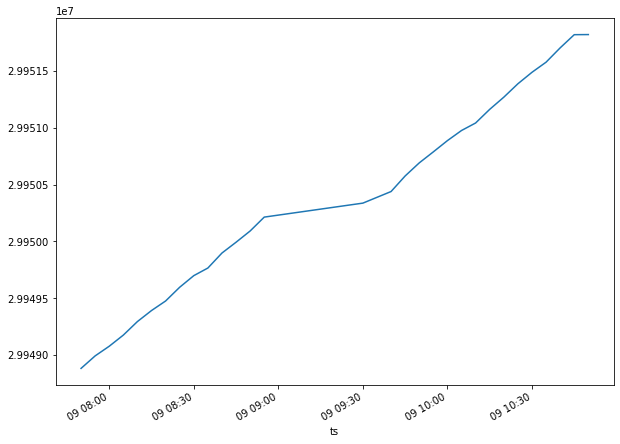

In [31]:
tmp['cnrgC'].iloc[-30:].plot(figsize=[10,7.5])

In [32]:
tmp = tmp.iloc[1:]
tmp = tmp.iloc[:-1]


In [33]:
tmp = tmp[['cnrgA','cnrgB','cnrgC']]

In [34]:
tmp['cnrgA'] = tmp['cnrgA'].apply(str)
tmp['cnrgB'] = tmp['cnrgB'].apply(str)
tmp['cnrgC'] = tmp['cnrgC'].apply(str)
tmp['ts'] = tmp.index.values.astype(np.int64) // 10 ** 6
tmp['ts'] = tmp['ts'].astype(int)
tmp.set_index('ts',inplace = True, drop = True)
nrgdict = tmp.to_dict('index')
nrgdict

{1611223200000: {'cnrgA': '25537471',
  'cnrgB': '25282489',
  'cnrgC': '29588014'},
 1611223500000: {'cnrgA': '25537745',
  'cnrgB': '25282713',
  'cnrgC': '29588220'},
 1611223800000: {'cnrgA': '25537930',
  'cnrgB': '25282862',
  'cnrgC': '29588392'},
 1611224100000: {'cnrgA': '25538169',
  'cnrgB': '25283047',
  'cnrgC': '29588579'},
 1611224400000: {'cnrgA': '25538425',
  'cnrgB': '25283262',
  'cnrgC': '29588781'},
 1611224700000: {'cnrgA': '25538624',
  'cnrgB': '25283423',
  'cnrgC': '29588944'},
 1611225000000: {'cnrgA': '25538822',
  'cnrgB': '25283578',
  'cnrgC': '29589115'},
 1611225300000: {'cnrgA': '25539033',
  'cnrgB': '25283752',
  'cnrgC': '29589291'},
 1611225600000: {'cnrgA': '25539214',
  'cnrgB': '25283891',
  'cnrgC': '29589432'},
 1611225900000: {'cnrgA': '25539408',
  'cnrgB': '25284042',
  'cnrgC': '29589586'},
 1611226200000: {'cnrgA': '25539621',
  'cnrgB': '25284206',
  'cnrgC': '29589758'},
 1611226500000: {'cnrgA': '25539764',
  'cnrgB': '25284311',
  'c

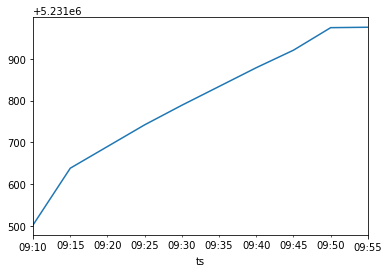

In [68]:
tmp['cnrgB'].iloc[-10:].plot()

In [35]:
tmp.to_csv('097.csv')
